In [1]:
import pickle# load the model from disk
import numpy as np
import pandas as pd
import cv2 as cv

from matplotlib.image import imread
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras

# importación de librerías propias
from src.utils import tools
from src.utils.mysql_driver import MySQL
import src.utils.mysql_driver as drv

# generación del set de test
batch_size = 32   # tamaño de los conjuntos de entrenamiento que se le pasan al modelo para que no aprenda todo de golpe y no se bloquee.
img_height = 144
img_width = 144
flag_first_exec = 0
signs_names = ['no_speed', 'speed100', 'speed120', 'speed20', 'speed30', 'speed50', 'speed60', 'speed70', 'speed80']

### CARGA DE LOS MODELOS SOLO EN LA PRIMERA EJECUCIÓN ####
# MODELO OPCIÓN 0 ###
model_vgg16_signs0 = keras.models.load_model('./models/model_vgg16_signs0.h5')

# MODELO OPCIÓN 1 ###
model_vgg16_class1 = keras.models.load_model('./models/model_vgg16_class1.h5')
model_vgg16_signs1 = keras.models.load_model('./models/model_vgg16_signs1.h5')

# MODELO OPCIÓN 2 ###
model_vgg16_class2 = keras.models.load_model('./models/model_vgg16_class2.h5')
model_vgg16_signs2 = keras.models.load_model('./models/model_vgg16_signs2.h5')

# Generación del conjunto de X_test
df_dict = []
# data_path = os.getcwd() + os.sep + 'documentation' + os.sep + 'Alemania' + os.sep + 'Test'  # predicción de las imágenes de Test (12k+)
data_path = os.getcwd() + os.sep + 'data' + os.sep + 'data_test'  # predicción de una parte de las imágenes de Test (1000)
only_image_names = [f for f in listdir(data_path) if isfile(join(data_path, f))]

# cargar imágenes con 32 bits
for image_name in only_image_names:
    if ".png" in image_name:           # se reduce el set de set (este notebook solo sirve para comprobar que el modelo se carga)   
        image_fullpath = data_path + os.sep + image_name
        image_cv = cv.imread(image_fullpath)     # con el 0 se lee en blanco y negro, sin nada, se lee en color

        # las imagenes originales tienen tamañanos distintos  -> con esta función se ponen en el tamaño común para todas (y será el tamaño de entrada al modelo)
        image_cv = cv.resize(image_cv, (img_height, img_width)) 
        df_dict.append({'image':image_cv})

df = pd.DataFrame(df_dict)
X_test_32 = np.stack(np.array(df["image"]))
X_test_32_1 = X_test_32     #/255
X_test_32_1.shape

(100, 144, 144, 3)

In [2]:
### creación de la lista donde quedarán registradas las predicciones
sql_list = []

### PREDICCIONES ####
# Variables de predicción de señal (tanto final como cada modelo)
Y_pred = []         # predicción final 
Y_pred_mod0 = []    # predicción modelo 0
Y_pred_mod1 = []    # predicción modelo 1
Y_pred_mod2 = []    # predicción modelo 2


for i in range(len(X_test_32_1)):
    # imagen a analizar
    img_analisis = X_test_32_1[i].reshape(1,144,144,3)

    ### PREDICCIONES MODELO 0 ###
    pred_mod0 = np.argmax(model_vgg16_signs0.predict(img_analisis))
    Y_pred_mod0.append(pred_mod0)

    ### PREDICCIONES MODELO 1 ###
    predictions_vgg16_class1 = model_vgg16_class1.predict(img_analisis)
    if np.argmax(predictions_vgg16_class1) == 2:
        predictions_vgg16_signs1 = model_vgg16_signs1.predict(img_analisis)

        # se añade 1 a la clase de la señal ya que este submodelo no tiene en cuenta la clase 'no_speed'
        pred_mod1 = np.argmax(predictions_vgg16_signs1)+1
        Y_pred_mod1.append(pred_mod1)      
    else:
        Y_pred_mod1.append(0)
    
    ### PREDICCIONES MODELO 2 ###
    predictions_vgg16_class2 = model_vgg16_class2.predict(img_analisis)
    if np.argmax(predictions_vgg16_class2) == 2:
        predictions_vgg16_signs2 = model_vgg16_signs2.predict(img_analisis)
        pred_mod2 = np.argmax(predictions_vgg16_signs2)
        Y_pred_mod2.append(pred_mod2)
    else:
        Y_pred_mod2.append(0)

    ### PREDICCIÓN CONJUNTA ######
    Y_pred.append([Y_pred_mod0[i], Y_pred_mod1[i], Y_pred_mod2[i]])

    ### creación de la línea del dataframe
    sql_list.append([only_image_names[i], signs_names[Y_pred_mod0[i]], signs_names[Y_pred_mod1[i]], signs_names[Y_pred_mod2[i]], signs_names[tools.most_frequent(Y_pred[i])]])


In [3]:
# SQL
# creación del dataframe que se va a subir a la BBDD
df_sql = pd.DataFrame(sql_list, columns=['pic_name', 'pred_m0', 'pred_m1', 'pred_m2', 'pred_model'])

# lectura de los datos de conexión a la base de datos y generación de las variables para conectarse
json_readed = tools.read_json_to_dict("src" + os.sep + "utils" + os.sep + "sql_settings.json")
IP_DNS = json_readed["IP_DNS"]
USER = json_readed["USER"]
PASSWORD = json_readed["PASSWORD"]
BD_NAME = json_readed["BD_NAME"]
PORT = json_readed["PORT"]

# generación de la instancia de BDD y lanzamiento de conexión
mysql_db = MySQL(IP_DNS=IP_DNS, USER=USER, PASSWORD=PASSWORD, BD_NAME=BD_NAME, PORT=PORT)
mysql_db.connect()

# se generan los elementos necesarios para crear la tabla de la base de datos
valores = df_sql.dtypes

sql_create_columns = ""
for i in range(len(valores)):
    row = drv.replace_guion(valores.index[i].upper()) + ' ' + drv.define_SQL_type(str(valores.values[i])) + ' NOT NULL,'
    sql_create_columns += row

# Create table as per requirement
# Erase table if exiting already 
mysql_db.execute_interactive_sql(sql="DROP TABLE IF EXISTS miguel_barquero_delpozo")

# Create the table to hold the data from the data set
# Create the table with the columns automatically
create_table_sql = f"""CREATE TABLE miguel_barquero_delpozo(
    ID INT(11) NOT NULL AUTO_INCREMENT,
    MOMENTO TIMESTAMP NOT NULL,
    {sql_create_columns}
    PRIMARY KEY (ID))"""

mysql_db.execute_interactive_sql(sql=create_table_sql)

# create the loop to insert automatically all the rows in the dataframe
sql_insert_columns = ""
for i in range(len(valores)):
    row =',' +  drv.replace_guion(valores.index[i].upper())
    sql_insert_columns += row

for i in range (len (df_sql)):
    values_list = df_sql.iloc[i].to_list()
    sql_insert_values = ""
    for elem in values_list:
        sql_insert_values += ", '" + str(elem) + "'"

    insert_row_sql = f"""INSERT INTO miguel_barquero_delpozo 
    (MOMENTO{sql_insert_columns})
                VALUES 
    (NOW(){sql_insert_values})"""

    mysql_db.execute_interactive_sql(sql=insert_row_sql)

Connected to MySQL server [05290575t_ds_april_2021_db]
Executed 

DROP TABLE IF EXISTS miguel_barquero_delpozo

 successfully
Executed 

CREATE TABLE miguel_barquero_delpozo(
    ID INT(11) NOT NULL AUTO_INCREMENT,
    MOMENTO TIMESTAMP NOT NULL,
    PIC_NAME VARCHAR(255) NOT NULL,PRED_M0 VARCHAR(255) NOT NULL,PRED_M1 VARCHAR(255) NOT NULL,PRED_M2 VARCHAR(255) NOT NULL,PRED_MODEL VARCHAR(255) NOT NULL,
    PRIMARY KEY (ID))

 successfully
Executed 

INSERT INTO miguel_barquero_delpozo 
    (MOMENTO,PIC_NAME,PRED_M0,PRED_M1,PRED_M2,PRED_MODEL)
                VALUES 
    (NOW(), '00000.png', 'no_speed', 'no_speed', 'no_speed', 'no_speed')

 successfully
Executed 

INSERT INTO miguel_barquero_delpozo 
    (MOMENTO,PIC_NAME,PRED_M0,PRED_M1,PRED_M2,PRED_MODEL)
                VALUES 
    (NOW(), '00001.png', 'speed50', 'speed30', 'speed30', 'speed30')

 successfully
Executed 

INSERT INTO miguel_barquero_delpozo 
    (MOMENTO,PIC_NAME,PRED_M0,PRED_M1,PRED_M2,PRED_MODEL)
                VAL

In [4]:
mysql_db.close()

Close connection with MySQL server [05290575t_ds_april_2021_db]


# visualización de predicciones

In [6]:
booster = 20

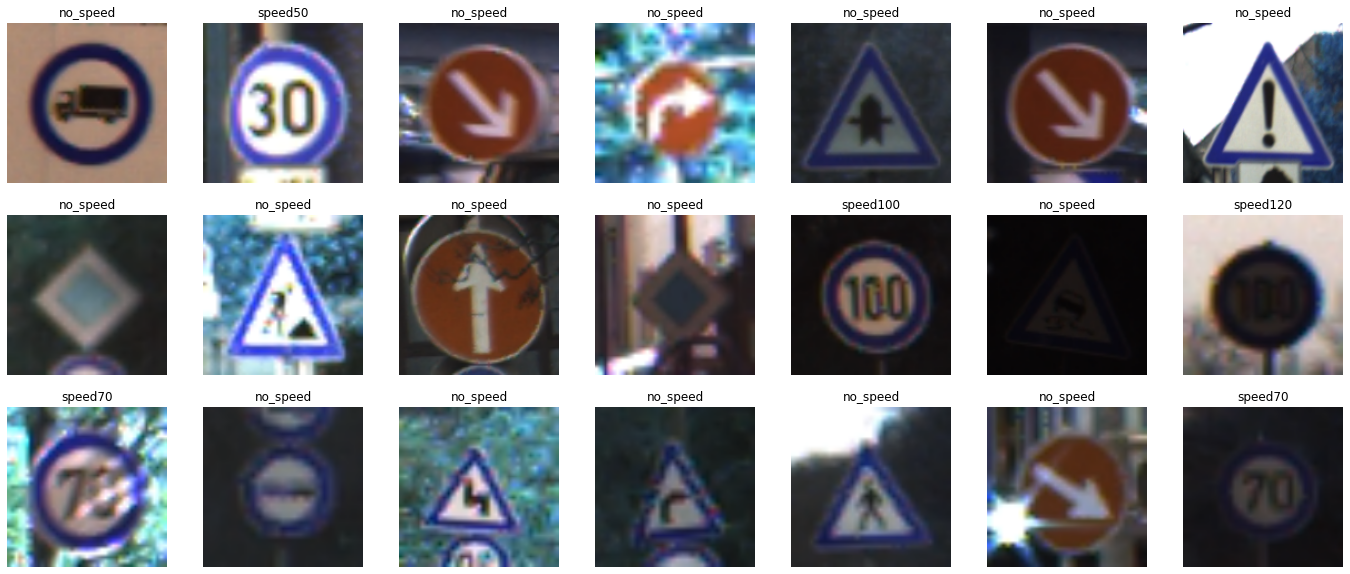

In [7]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i+booster])
    plt.title(signs_names[Y_pred_mod0[i+booster]])
    plt.axis("off")

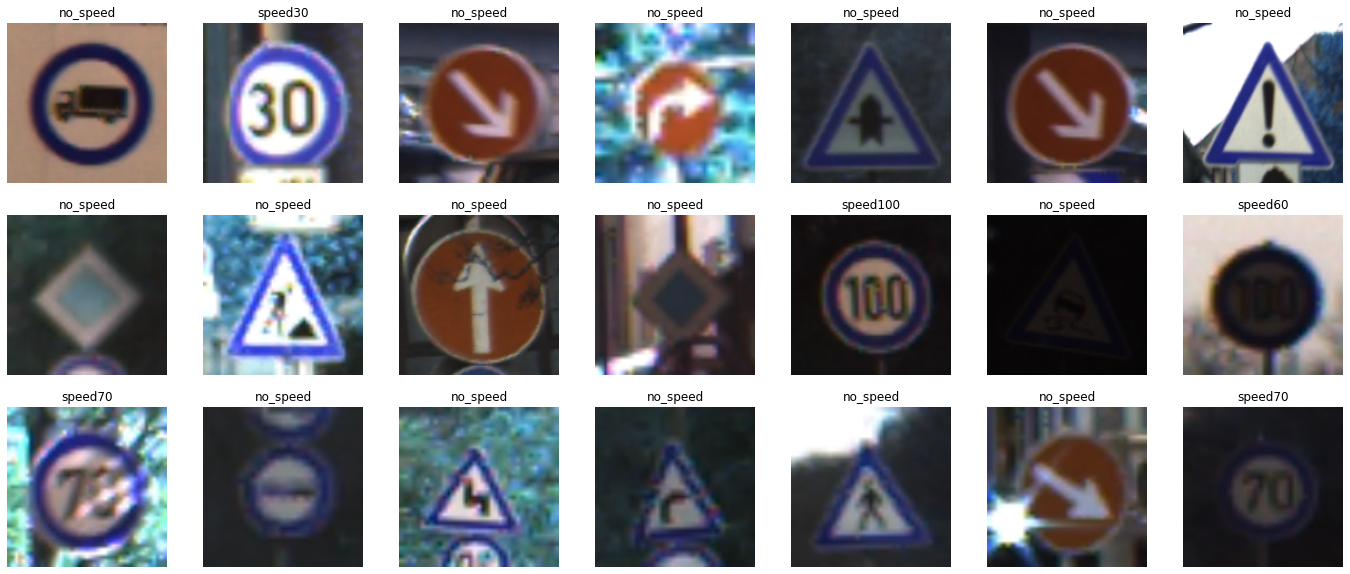

In [8]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i+booster])
    plt.title(signs_names[Y_pred_mod1[i+booster]])
    plt.axis("off")

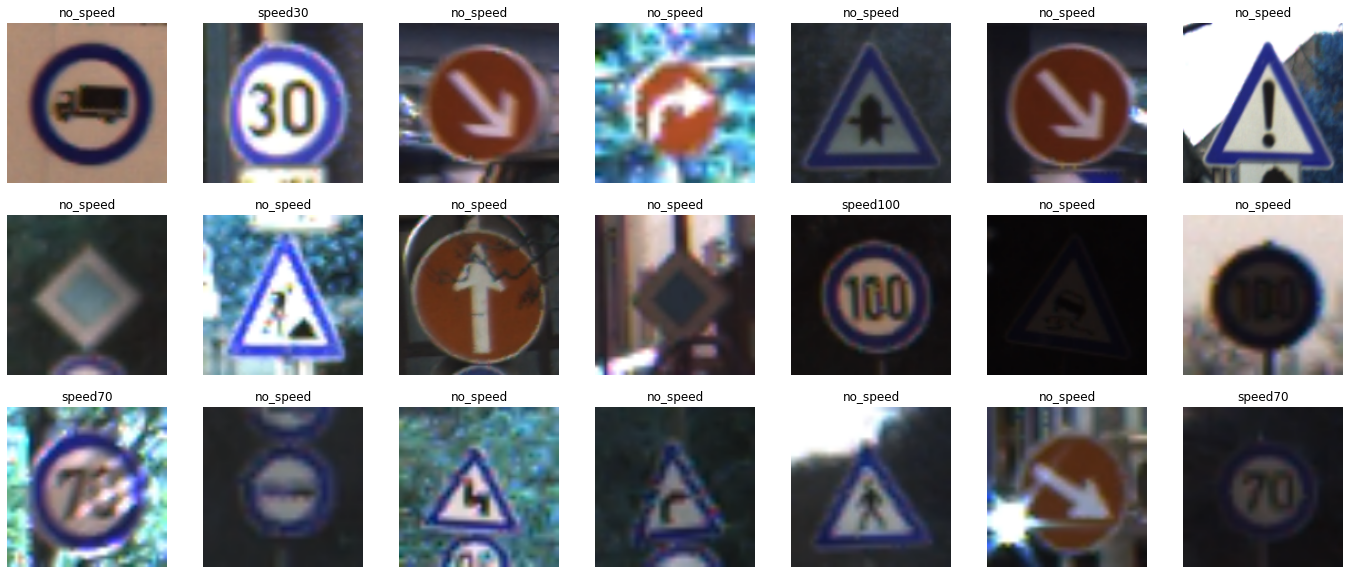

In [9]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i+booster])
    plt.title(signs_names[Y_pred_mod2[i+booster]])
    plt.axis("off")

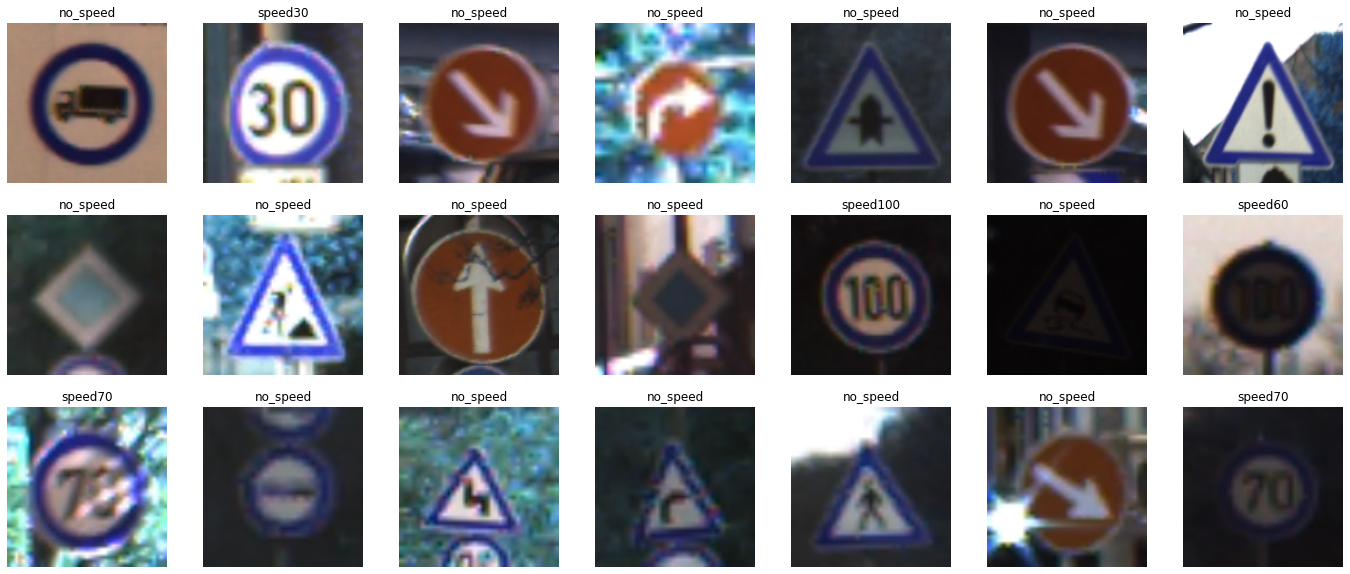

In [10]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i+booster])
    plt.title(signs_names[tools.most_frequent(Y_pred[i+booster])])
    plt.axis("off")